## **An Interactive Guide for Basic Pure Pursuit Implementation in VRC**
* **Created by:** Sarah 97963A

<img src = "https://drive.google.com/uc?export=view&id=1vOeu62RpnoZWuw04mK8S6ubQs2NYi3fT" align = "left" width = "280">

## **What Do You Need to Know Before Trying to Implement the Pure Pursuit Controller Yourself?**
* Working knowledge of feedback control loops such as [PID](https://docs.google.com/document/d/1D61dinGqP__CHzRfc9yNugnS9K-JTa395_r0qP7L5W8/edit?usp=sharing)
* A functioning [Position Tracking (odometry)](https://www.vexforum.com/t/team-5225-introduction-to-position-tracking-document/49640) system
* Basic programming knowledge (arrays and loops)
* High school level math such as trigonomotry

## **Important Note**
* If you have any comments/suggestions, encountered issues with the code, or have questions about the document, please contact Sarah (vexforum `@sarah_97963a`, discord `@Sarah 97963A#2509`)


## **Import Necessary Libraries**
* To run a cell, press shift + enter
* The cells need to be executed sequentially to work
* Read more about JupyterLab and Google Colab [here](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib.animation as animation
from IPython import display

## **Helper Functions for Graphing**
* Below are some helper functions to help visualize the output of pure pursuit and path generator
* Feel free to modified these functions to graph lines in the style you like

In [ ]:
def add_line (path) :
    for i in range (0,len(path)):
        plt.plot(path[i][0],path[i][1],'.',color='red',markersize=10)

    for i in range(0,len(path)-1):
        plt.plot([path[i][0],path[i+1][0]],[path[i][1],path[i+1][1]],color='b')

    plt.axis('scaled')
    # plt.show()

def add_complicated_line (path,lineStyle,lineColor,lineLabel) :
    for i in range (0,len(path)):
        plt.plot(path[i][0],path[i][1],'.',color='red',markersize=10)

    for i in range(0,len(path)-1):
        if(i == 0):
            # plt.plot([path[i][0],path[i+1][0]],[path[i][1],path[i+1][1]],color='b')
            plt.plot([path[i][0],path[i+1][0]],[path[i][1],path[i+1][1]],lineStyle,color=lineColor,label=lineLabel)
        else:
            plt.plot([path[i][0],path[i+1][0]],[path[i][1],path[i+1][1]],lineStyle,color=lineColor)

    plt.axis('scaled')

def highlight_points (points, pointColor):
    for point in points :
        plt.plot(point[0], point[1], '.', color = pointColor, markersize = 10)

def draw_circle (x, y, r, circleColor):
    xs = []
    ys = []
    angles = np.arange(0, 2.2*np.pi, 0.2)

    for angle in angles :
        xs.append(r*np.cos(angle) + x)
        ys.append(r*np.sin(angle) + y)

    plt.plot(xs, ys, '-', color = circleColor)

## **What is the Pure Pursuit Controller?**

The pure pursuit controller is an automatic steering method for wheeled mobile robots. It is a steering method, which means it computes the necessary augular velocity for a wheeled robot to stay on pre-computed paths. Linear velocity is assumed to be constant. Therefore, an additional velocity controller of your choice is needed if you wish to slow down the robot as it aproaches the target (something as simple as a proportional controller could work). During the 2020-2021 VRC season, our team used the pure pursuit controller for the programming skills challenge and acheived great results. Videos of our robot in action can be found [here](https://www.youtube.com/watch?v=KE7NF-hdAeA).

Read a brief introduction of the pure pursuit controller by MathWorks [here](https://www.mathworks.com/help/robotics/ug/pure-pursuit-controller.html).

A quick demostration of path tracking using the pure pursuit controller:

<img src = "https://drive.google.com/uc?export=view&id=14zvxcyIhl1vwtxWBDycwADGxsop9FWZr" width = "500">

In the animation shown above, the dotted gray line is the pre-computed path that the robot needs to follow and the solid black line is the robot's trajectory. The big yellow dot and the short red line represent the robot's current position and heading. There is another solid green line connecting the point the robot is "chasing after" and the robot's current position, but it's very hard to see in this demo. Although the robot's trajectory does not match with the path perfectly, the pure pursuit controller still performed decently well.

In the sections below, we will implement a basic pure pursuit controller for a differential drive (NOT the type of differential commonly used for power sharing in VRC), a robot model fairly similar to the 4 wheel tank drives in VRC.

## **Limitations**

As shown above, the pure pursuit controller cannot trace a path perfectly due to the non-zero look ahead distance. The more sharp corners the path contains, the worse the performance. There are two ways to achieve better performance under the presence of sharp corners:
* Optimize the path during the path generation process
* Make improvements to the pure pursuit controller itself

For most circumstances in the VRC competition, the basic pure pursuit controller will suffice even without the above two improvements.

## **How does it work?**

The key of the pure pursuit controller involves calculating a goal point on the path that is a certain distance $l_d$, which is called the look ahead distance, from the robot's current position. Then, the goal point is used to calculate the appropiate angular velocity needed for the robot to move toward that point. As the robot moves forward, a different goal point on the path will be selected and the robot's angular velocity will be updated. Since the robot can never reach this goal point and the goal point stays on the path, the end result would be the robot tracing the path.

<img src = "https://drive.google.com/uc?export=view&id=1jmdqr-PTy_d3cYwSzLCHyDsnREXv7anS" width = "500">

To find the appropiate goal point for the robot to follow mathematically, a circle centered at the robot's current position with radis $l_d$ is made. The circle's intersections with the path are the potential goal points. We will return to this part of the algorithm later in the document.

A more intuitive way of understanding and visualizing the pure pursuit controller would be the GIF below:

<img src = "https://drive.google.com/uc?export=view&id=1KANlY7MCNq-mvQy2ZzGpkdqB5fzIDIG8" width = "500">

The carrot is always at a constant distance away from the donkey so the donkey moves in the direction the rider wants by chasing after the carrot.

In our implementation of the pure pursuit controller, the path is a 2D array represented by equally spaced points (1D array). The basic algorithm is to use a for loop to go through each pair of points to determine if there are any intersections within each line segments. If goal points are found, follow the most appropiate one. These steps will be repeated until the end of the path is reached.

<img src = "https://drive.google.com/uc?export=view&id=1mXW5iExsInklWfwXmfW8KyGNs8JicebO" width = "800">


## **Line-Circle Intersection**

Let's start by looking at the basic math behind choosing goal points -- the line-circle intersection. There are multiple ways to find the instersection, we have found that [this method](https://mathworld.wolfram.com/Circle-LineIntersection.html) (the screenshot below) was the easiest to implement and debug. (Side note: the math here might look a bit terrifying, but it's okay if you don't fully understand how it works. This statement only applies to this section.)

<img src = "https://drive.google.com/uc?export=view&id=182XfvWoYVHroI1VItT317mg1F3445JMs">

In the method presented above, the circle is assumed to be centered at the the origin. In our application, the circle would be centered at the robot's current position `[currentX, currentY]` and the two points that define the line would be arbitrary points `pt1 = [x1, y1]` and `pt2 = [x2, y2]`. Therefore, to apply this method, we first need to subtract `currentX` and `currentY` from `[x1, y1]` and `[x2, y2]` to center the system at origin. Again, we perform such offsets so that we can use the method from the screenshot above, which requires the circle to be centered at the origin.

<img src = "https://drive.google.com/uc?export=view&id=1BtdDv5yw_T6iP_shfrqQ1JILTxxP0RCQ">

In the code cell below, you are encouraged to code such line-circle intersection algorithm yourself. If you do not know python at all, completed code with comments is provided.

In [ ]:
# helper function: sgn(num)
# returns -1 if num is negative, 1 otherwise
def sgn (num):
  if num >= 0:
    return 1
  else:
    return -1

# currentPos: [currentX, currentY]
# pt1: [x1, y1]
# pt2: [x2, y2]
def line_circle_intersection (currentPos, pt1, pt2, lookAheadDis):

  # extract currentX, currentY, x1, x2, y1, and y2 from input arrays
  # DO NOT modified these variables!
  currentX = currentPos[0]
  currentY = currentPos[1]
  x1 = pt1[0]
  y1 = pt1[1]
  x2 = pt2[0]
  y2 = pt2[1]

  # boolean variable to keep track of if intersections are found
  # remember to set this correctly for the graphing functions to work!
  intersectFound = False

  # your code goes here
  # output (intersections found) should be stored in arrays sol1 and sol2 in the form of sol1 = [sol1_x, sol1_y]
  # if two solutions are the same, store the same values in both sol1 and sol2





  # graphing functions to visualize the outcome
  # ---------------------------------------------------------------------------------------------------------------------------------------
  plt.plot ([x1, x2], [y1, y2], '--', color='grey')
  draw_circle (currentX, currentY, lookAheadDis, 'orange')
  if intersectFound == False :
    print ('No intersection Found!')
  else:
    print ('Solution 1 found at [{}, {}]'.format(sol1[0], sol1[1]))
    print ('Solution 2 found at [{}, {}]'.format(sol2[0], sol2[1]))
    plt.plot ([sol1[0]], [sol1[1]], '.', weight=8, color='red', label='sol1')
    plt.plot ([sol2[0]], [sol2[1]], '.', weight=8, color='blue', label='sol2')
    plt.legend()

  plt.axis('scaled')
  plt.show()

# now call this function and see the results!
line_circle_intersection ([0, 1], [2, 3], [-2, -4], 0.9)

### Line-Circle Intersection: Commented Code Example

Solution 1 found at [0.9775486035159696, 1.2107100561529465]
Solution 2 found at [0.314759088791723, 0.05082840538551481]


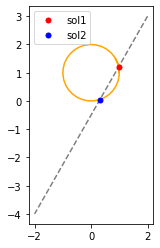

In [ ]:
# helper function: sgn(num)
# returns -1 if num is negative, 1 otherwise
def sgn (num):
  if num >= 0:
    return 1
  else:
    return -1

# currentPos: [currentX, currentY]
# pt1: [x1, y1]
# pt2: [x2, y2]
def line_circle_intersection (currentPos, pt1, pt2, lookAheadDis):

  # extract currentX, currentY, x1, x2, y1, and y2 from input arrays
  currentX = currentPos[0]
  currentY = currentPos[1]
  x1 = pt1[0]
  y1 = pt1[1]
  x2 = pt2[0]
  y2 = pt2[1]

  # boolean variable to keep track of if intersections are found
  intersectFound = False

  # output (intersections found) should be stored in arrays sol1 and sol2
  # if two solutions are the same, store the same values in both sol1 and sol2

  # subtract currentX and currentY from [x1, y1] and [x2, y2] to offset the system to origin
  x1_offset = x1 - currentX
  y1_offset = y1 - currentY
  x2_offset = x2 - currentX
  y2_offset = y2 - currentY

  # calculate the discriminant using equations from the wolframalpha article
  dx = x2_offset - x1_offset
  dy = y2_offset - y1_offset
  dr = math.sqrt (dx**2 + dy**2)
  D = x1_offset*y2_offset - x2_offset*y1_offset
  discriminant = (lookAheadDis**2) * (dr**2) - D**2

  # if discriminant is >= 0, there exist solutions
  if discriminant >= 0:
    intersectFound = True

    # calculate the solutions
    sol_x1 = (D * dy + sgn(dy) * dx * np.sqrt(discriminant)) / dr**2
    sol_x2 = (D * dy - sgn(dy) * dx * np.sqrt(discriminant)) / dr**2
    sol_y1 = (- D * dx + abs(dy) * np.sqrt(discriminant)) / dr**2
    sol_y2 = (- D * dx - abs(dy) * np.sqrt(discriminant)) / dr**2

    # add currentX and currentY back to the solutions, offset the system back to its original position
    sol1 = [sol_x1 + currentX, sol_y1 + currentY]
    sol2 = [sol_x2 + currentX, sol_y2 + currentY]

  # graphing functions to visualize the outcome
  # ---------------------------------------------------------------------------------------------------------------------------------------
  plt.plot ([x1, x2], [y1, y2], '--', color='grey')
  draw_circle (currentX, currentY, lookAheadDis, 'orange')
  if intersectFound == False :
    print ('No intersection Found!')
  else:
    print ('Solution 1 found at [{}, {}]'.format(sol1[0], sol1[1]))
    print ('Solution 2 found at [{}, {}]'.format(sol2[0], sol2[1]))
    plt.plot (sol1[0], sol1[1], '.', markersize=10, color='red', label='sol1')
    plt.plot (sol2[0], sol2[1], '.', markersize=10, color='blue', label='sol2')
    plt.legend()

  plt.axis('scaled')
  plt.show()

# now call this function and see the results!
line_circle_intersection ([0, 1], [2, 3], [-2, -4], 1)

## Line-Circle Intersection with Bounds

You might have already noticed something not quite right when messing with the algorithm above. Under certain condition, although the intersections found are on the inifinite line defined by `pt1` and `pt2`, they are not exactly within the range of `[x1, y1]` and `[x2, y2]`. Consider the situation illustrated below:

<img src = "https://drive.google.com/uc?export=view&id=1PSJrTmdBgR0MMcUj8C8uN3q9VHDVYY4I" width = "300">

Although intersections are found, they are not within any of the line segments in the path. Those are not the points we want the robot to follow! So how do we prevent such situation from happening?

The solution is simple. After intersections are found, we check to see if their x values are within the range of `[min(x1, x2), max(x1, x2)]` and their y values are within the range of `[min(y1, y2), max(y1, y2)]`. That is, for a solution to be valid and `intersectFound` to be `True`, the following conditions need to be satisfied:
```
discriminant >= 0
min(x1, x2) <= sol_x <= max(x1, x2)
min(y1, y2) <= sol_y <= max(y1, y2)
```

You can modify your `line_circle_intersection` function in the code cell below. Completed and commented code is also provided.

(Side note: use `(a >= x) && (x >= b)` in VEXCode.)

In [ ]:
# helper function: sgn(num)
# returns -1 if num is negative, 1 otherwise
def sgn (num):
  if num >= 0:
    return 1
  else:
    return -1

# currentPos: [currentX, currentY]
# pt1: [x1, y1]
# pt2: [x2, y2]
def line_circle_intersection (currentPos, pt1, pt2, lookAheadDis):

  # extract currentX, currentY, x1, x2, y1, and y2 from input arrays
  # DO NOT modified these variables!
  currentX = currentPos[0]
  currentY = currentPos[1]
  x1 = pt1[0]
  y1 = pt1[1]
  x2 = pt2[0]
  y2 = pt2[1]

  # boolean variable to keep track of if intersections are found
  # remember to set this correctly for the graphing functions to work!
  intersectFound = False

  # your code goes here
  # output (intersections found) should be stored in arrays sol1 and sol2 in the form of sol1 = [sol1_x, sol1_y]
  # hint: if two solutions are the same, store the same values in both sol1 and sol2




  # add boundary checking code here
  # for now, the function should print out 'solution _ is valid!' ( _ can be 1 or 2) if a solution point is within the range
  # we will use this outcome more in the next section





  # graphing functions to visualize the outcome
  # ---------------------------------------------------------------------------------------------------------------------------------------
  plt.plot ([x1, x2], [y1, y2], '--', color='grey')
  draw_circle (currentX, currentY, lookAheadDis, 'orange')
  if intersectFound == False :
    print ('No intersection Found!')
  else:
    print ('Solution 1 found at [{}, {}]'.format(sol1[0], sol1[1]))
    print ('Solution 2 found at [{}, {}]'.format(sol2[0], sol2[1]))
    plt.plot (sol1[0], sol1[1], '.', markersize=10, color='red', label='sol1')
    plt.plot (sol2[0], sol2[1], '.', markersize=10, color='blue', label='sol2')
    plt.legend()

  plt.axis('scaled')
  plt.show()

# now call this function and see the results!
line_circle_intersection ([0, 1], [2, 3], [-2, -4], 0.9)

### Line-Circle Intersection with Bounds: Commented Code Example

solution 1 is valid!
Solution 1 found at [0.7071067811865475, 1.7071067811865475]
Solution 2 found at [-0.7071067811865475, 0.29289321881345254]


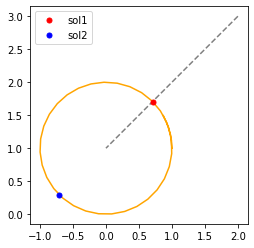

In [ ]:
# helper function: sgn(num)
# returns -1 if num is negative, 1 otherwise
def sgn (num):
  if num >= 0:
    return 1
  else:
    return -1

# currentPos: [currentX, currentY]
# pt1: [x1, y1]
# pt2: [x2, y2]
def line_circle_intersection (currentPos, pt1, pt2, lookAheadDis):

  # extract currentX, currentY, x1, x2, y1, and y2 from input arrays
  currentX = currentPos[0]
  currentY = currentPos[1]
  x1 = pt1[0]
  y1 = pt1[1]
  x2 = pt2[0]
  y2 = pt2[1]

  # boolean variable to keep track of if intersections are found
  intersectFound = False

  # output (intersections found) should be stored in arrays sol1 and sol2
  # if two solutions are the same, store the same values in both sol1 and sol2

  # subtract currentX and currentY from [x1, y1] and [x2, y2] to offset the system to origin
  x1_offset = x1 - currentX
  y1_offset = y1 - currentY
  x2_offset = x2 - currentX
  y2_offset = y2 - currentY

  # calculate the discriminant using equations from the wolframalpha article
  dx = x2_offset - x1_offset
  dy = y2_offset - y1_offset
  dr = math.sqrt (dx**2 + dy**2)
  D = x1_offset*y2_offset - x2_offset*y1_offset
  discriminant = (lookAheadDis**2) * (dr**2) - D**2

  # if discriminant is >= 0, there exist solutions
  if discriminant >= 0:

    # calculate the solutions
    sol_x1 = (D * dy + sgn(dy) * dx * np.sqrt(discriminant)) / dr**2
    sol_x2 = (D * dy - sgn(dy) * dx * np.sqrt(discriminant)) / dr**2
    sol_y1 = (- D * dx + abs(dy) * np.sqrt(discriminant)) / dr**2
    sol_y2 = (- D * dx - abs(dy) * np.sqrt(discriminant)) / dr**2

    # add currentX and currentY back to the solutions, offset the system back to its original position
    sol1 = [sol_x1 + currentX, sol_y1 + currentY]
    sol2 = [sol_x2 + currentX, sol_y2 + currentY]

    # find min and max x y values
    minX = min(x1, x2)
    maxX = max(x1, x2)
    minY = min(y1, y2)
    maxY = max(y1, y2)

    # check to see if any of the two solution points are within the correct range
    # for a solution point to be considered valid, its x value needs to be within minX and maxX AND its y value needs to be between minY and maxY
    # if sol1 OR sol2 are within the range, intersection is found
    if (minX <= sol1[0] <= maxX and minY <= sol1[1] <= maxY) or (minX <= sol2[0] <= maxX and minY <= sol2[1] <= maxY) :
      intersectFound = True

      # now do a more detailed check to determine which point is valid, which is not
      if (minX <= sol1[0] <= maxX and minY <= sol1[1] <= maxY) :
        print ('solution 1 is valid!')
      if (minX <= sol2[0] <= maxX and minY <= sol2[1] <= maxY) :
        print ('solution 1 is valid!')

  # graphing functions to visualize the outcome
  # ---------------------------------------------------------------------------------------------------------------------------------------
  plt.plot ([x1, x2], [y1, y2], '--', color='grey')
  draw_circle (currentX, currentY, lookAheadDis, 'orange')
  if intersectFound == False :
    print ('No intersection Found!')
  else:
    print ('Solution 1 found at [{}, {}]'.format(sol1[0], sol1[1]))
    print ('Solution 2 found at [{}, {}]'.format(sol2[0], sol2[1]))
    plt.plot (sol1[0], sol1[1], '.', markersize=10, color='red', label='sol1')
    plt.plot (sol2[0], sol2[1], '.', markersize=10, color='blue', label='sol2')
    plt.legend()

  plt.axis('scaled')
  plt.show()

# now call this function and see the results!
line_circle_intersection ([0, 1], [2, 3], [0, 1], 1)

## **Choosing the Goal Point**

All possible outcomes of the line-circle intersections (with a single line segment) are the following:

* **Situation 1:**

  No intersection. If this is the case, the discriminant will be negative.

  <img src = "https://drive.google.com/uc?export=view&id=11oaYnwGv2iTTlezgedmuLfh3xMMhdW1t" width = '500'>

* **Situation 2:**

  Intersections are found, but they are not in between `(x1, y1)` and `(x2, y2)`. The discriminant is positive, but we should still consider this situation as “no intersection”.

  <img src = "https://drive.google.com/uc?export=view&id=18d4XfysFWOLThEoFXNATkl3cUfZJcRgj" width = '500'>

* **Situation 3:**

  There is one and only one intersection inside the range of `(x1, y1)` and `(x2, y2)`. The discriminant is positive, and the robot should follow the intersection found.

  <img src = "https://drive.google.com/uc?export=view&id=1vmlJPZXAsnwctsZvRC1txgLAASIkZQDL" width = '500'>

* **Situation 4:**

  There are two intersections and both are in between `(x1, y1)` and `(x2, y2)`. In this situation, we have to determine which point is better for the robot to follow. One method we can use is to calculate the distance between the intersections and the second point `(x2, y2)`(the path goes in the direction of `(x1, y1) -> (x2, y2)`) and pick the point that is closer to the second point (in other words, the point closer to the end of the path).

  <img src = "https://drive.google.com/uc?export=view&id=1YMenRgH_7gM9ENzWlALxlCOZGYLhN0VD" width = '500'>

* In some extreme cases where the robot is traveling through sharp corners, it might create multiple intersections with multiple line segments (as shown in the picture below). We can code our program in a way that the robot would follow the first valid point it found. This way, in extreme cases where the path overlaps itself or there exists multiple sharp corners, the robot would not skip a portion of the path altogether. In order to prevent the robot from going backwards in the path, we can create a variable `lastFoundIndex` to store the index of the point it just passed. Every time the loop runs, it will only check the points that are located after `path[lastFoundIndex]`. This way, **the segments the robot has already traveled through will not be checked again for intersections**. In the cases that no new intersection has been found (robot deviates from the path), the robot will follow the point at `lastFoundIndex`.

  <img src = "https://drive.google.com/uc?export=view&id=1eLvmfW8sUFdXZ6v-ux5Qc9aK5gSb6_L_" width = '500'>

Let's take a closer look at how `lastFoundIndex` and the goal point choosing function should work.

When the robot first entered the path (the 1st loop iteration), `lastFoundIndex = 0`. The line-circle intersection search starts from `path[0]`, an intersection is found and selected as the goal point for the robot to move toward.

<img src = "https://drive.google.com/uc?export=view&id=1a98GfCO40hIdLIPWeysSEucpXnu53Kyq" width = '500'>

At the end of the 1st loop iteration, `lastFoundIndex` is updated to 0 since the goal point was found in between `path[0]` and `path[1]`. When the 2nd loop iteration starts, the robot has moved closer to `path[1]`. Since `lastFoundIndex` is still 0, the line-circle intersection starts from `path[0]` again. This time, there are two intersections with the path: one located in between `path[0]` and `path[1]` and the other located in between `path[1]` and `path[2]`.

<img src = "https://drive.google.com/uc?export=view&id=1CfDQ_1PFp70N3qRDDzvktap2PVyn16cc" width = '500'>

Following normal precedure, the algorithm would choose the intersection in between `path[0]` and `path[1]` as the goal point and breaks out of the search loop. As we can tell from the picture below, it's not a very good choice since it will cause the robot to go backward. To avoid such bad goal point choice, we can add an additional condition to evaluate the goal point found by the algorithm: **the search loop break statement can only be reached if the distance between the goal point chosen and the next point in path is shorter than the distance between the robot's current position and the next point in path**. If the above statement is not true, the search loop continues. We can also increment `lastFoundIndex` in case the robot fails to find intersections in the next line segment. This will prevent the robot from going backward since `path[lastFoundIndex]` will become the goal point when no intersection can be found.

Equivalent pseudo code:
```
if pt_to_pt_distance (goalPt, path[i+1]) < pt_to_pt_distance (currentPos, path[i+1]) :
  break
else:
  lastFoundIndex += 1
  continue
```
In the situation illustrated below, it is obvious that the distance between the `goalPt` (the left intersection) and `path[1]` is greater that the distance between `currentPos` and `path[1]` (both distance are marked with dotted red line). Hence, the search loop continues and the intersection between `path[1]` and `path[2]` will be chosen in the next search loop iteration.

<img src = "https://drive.google.com/uc?export=view&id=1DSNyY11SmCa1uj9OP2KH2g6W7A2OJPxn" width = '500'>

At the end of the 2nd loop iteration, `lastFoundIndex` is updated to 1. When the 3rd loop iteration starts, the next search will start from `path[1]` so the intersection in between `path[0]` and `path[1]` will be ignored. The portion of the path ignored for goal point searching is marked in brown.

<img src = "https://drive.google.com/uc?export=view&id=1z3mhGdsqP3kHyh4a2WBIHARaBMA3REGN" width = '500'>

The code cell below can be used for implementing the `goal_pt_search` algorithm yourself (for people that are not familiar enough with python, commented code is provided as before). A sample path has been provided.


In [ ]:
# implement the goal_pt_search algorithm
# last section of the visualization code needs to be uncommented when the function is done!!
# you will need the line-circle intersection with bounds algorithm completed in previous sections
path1 = [[0.0, 0.0], [0.011580143395790051, 0.6570165243709267], [0.07307496243411533, 1.2724369146199181], [0.3136756819515748, 1.7385910188236868], [0.8813313906933087, 1.9320292911046681], [1.6153051608455251, 1.9849785681091774], [2.391094224224885, 1.9878393390954208], [3.12721333474683, 1.938831731115573], [3.685011039017028, 1.7396821576569221], [3.9068092597113266, 1.275245079016133], [3.9102406525571713, 0.7136897450501469], [3.68346383786099, 0.2590283720040381], [3.1181273273535957, 0.06751996250999465], [2.3832776875784316, 0.013841087641154892], [1.5971423891000605, 0.0023698980178599423], [0.7995795475309813, 0.0003490964043320208], [0, 0]]

# helper functions
def pt_to_pt_distance (pt1,pt2):
    distance = np.sqrt((pt2[0] - pt1[0])**2 + (pt2[1] - pt1[1])**2)
    return distance

# returns -1 if num is negative, 1 otherwise
def sgn (num):
  if num >= 0:
    return 1
  else:
    return -1

def goal_pt_search (path, currentPos, lookAheadDis, lastFoundIndex) :

  # initialize goalPt in case no intersection is found
  goalPt = [None, None]

  # use for loop to search intersections
  startingIndex = lastFoundIndex
  for i in range (startingIndex, len(path1)) :

    # your code goes here
    # store the final goal point in array goalPt = [goalPt_x, goalPt_y]
    # right now you can just run the function as is to see the visualization of the path
    # but when you are ready to code, the pass below needs to be removed
    pass





  # visualize outcome
  # ---------------------------------------------------------------------------------------------------------------------------------------
  # traveled path (path omitted for searching) will be marked in brown
  field = plt.figure()
  xscale,yscale = (1.5, 1.5)  # <- modify these values to scale the plot
  path_ax = field.add_axes([0,0,xscale,yscale])
  add_complicated_line(path[0:lastFoundIndex+1],'--','brown','traveled path')
  add_complicated_line(path[lastFoundIndex:len(path)],'--','grey','remaining path')
  highlight_points(path[0:lastFoundIndex], 'brown')
  highlight_points(path[lastFoundIndex:len(path)], 'grey')

  xMin, yMin, xMax, yMax = (-1, -1, 5, 3)  # <- modify these values to set plot boundaries
                                           # (minX, minY, maxX, maxY)

  # plot field
  path_ax.plot([xMin,xMax],[yMin,yMin],color='black')
  path_ax.plot([xMin,xMin],[yMin,yMax],color='black')
  path_ax.plot([xMax,xMax],[yMin,yMax],color='black')
  path_ax.plot([xMax,xMin],[yMax,yMax],color='black')

  # set grid
  xTicks = np.arange(xMin, xMax+1, 2)
  yTicks = np.arange(yMin, yMax+1, 2)

  path_ax.set_xticks(xTicks)
  path_ax.set_yticks(yTicks)
  path_ax.grid(True)

  path_ax.set_xlim(xMin-0.25,xMax+0.25)
  path_ax.set_ylim(yMin-0.25,yMax+0.25)

  # plot start and end
  path_ax.plot(path[0][0],path[0][1],'.',color='blue',markersize=15,label='start')
  path_ax.plot(path[-1][0],path[-1][1],'.',color='green',markersize=15,label='end')

  # plot current position and goal point
  draw_circle (currentPos[0], currentPos[1], lookAheadDis, 'orange')
  plt.plot (currentPos[0], currentPos[1], '.', markersize=15, color='orange', label='current position')
  if goalPt != [None, None] :
    plt.plot (goalPt[0], goalPt[1], '.', markersize=15, color='red', label='goal point')
    add_complicated_line([currentPos, goalPt], '-', 'black', 'look ahead distance')

  path_ax.legend()

# call the function to see the results
goal_pt_search (path1, [1, 2.2], 0.8, 3)

### Choosing the Goal Point: Commented Code Example


Goal point found at [1.5585593709195926, 1.9808848951854097]


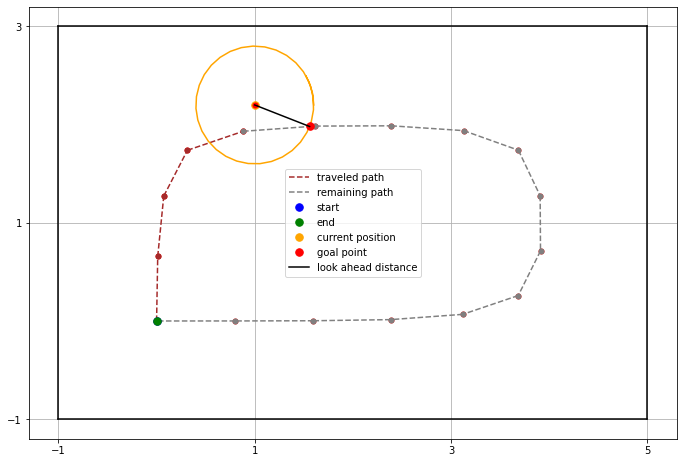

In [ ]:
path1 = [[0.0, 0.0], [0.011580143395790051, 0.6570165243709267], [0.07307496243411533, 1.2724369146199181], [0.3136756819515748, 1.7385910188236868], [0.8813313906933087, 1.9320292911046681], [1.6153051608455251, 1.9849785681091774], [2.391094224224885, 1.9878393390954208], [3.12721333474683, 1.938831731115573], [3.685011039017028, 1.7396821576569221], [3.9068092597113266, 1.275245079016133], [3.9102406525571713, 0.7136897450501469], [3.68346383786099, 0.2590283720040381], [3.1181273273535957, 0.06751996250999465], [2.3832776875784316, 0.013841087641154892], [1.5971423891000605, 0.0023698980178599423], [0.7995795475309813, 0.0003490964043320208], [0, 0]]

# helper functions
def pt_to_pt_distance (pt1,pt2):
    distance = np.sqrt((pt2[0] - pt1[0])**2 + (pt2[1] - pt1[1])**2)
    return distance

# returns -1 if num is negative, 1 otherwise
def sgn (num):
  if num >= 0:
    return 1
  else:
    return -1

def goal_pt_search (path, currentPos, lookAheadDis, lastFoundIndex) :

  # extract currentX and currentY
  currentX = currentPos[0]
  currentY = currentPos[1]

  # initialize goalPt in case no intersection is found
  goalPt = [None, None]

  # use for loop to search intersections
  intersectFound = False
  startingIndex = lastFoundIndex

  for i in range (startingIndex, len(path)-1):

    # beginning of line-circle intersection code
    x1 = path[i][0] - currentX
    y1 = path[i][1] - currentY
    x2 = path[i+1][0] - currentX
    y2 = path[i+1][1] - currentY
    dx = x2 - x1
    dy = y2 - y1
    dr = math.sqrt (dx**2 + dy**2)
    D = x1*y2 - x2*y1
    discriminant = (lookAheadDis**2) * (dr**2) - D**2

    if discriminant >= 0:
      sol_x1 = (D * dy + sgn(dy) * dx * np.sqrt(discriminant)) / dr**2
      sol_x2 = (D * dy - sgn(dy) * dx * np.sqrt(discriminant)) / dr**2
      sol_y1 = (- D * dx + abs(dy) * np.sqrt(discriminant)) / dr**2
      sol_y2 = (- D * dx - abs(dy) * np.sqrt(discriminant)) / dr**2

      sol_pt1 = [sol_x1 + currentX, sol_y1 + currentY]
      sol_pt2 = [sol_x2 + currentX, sol_y2 + currentY]
      # end of line-circle intersection code

      minX = min(path[i][0], path[i+1][0])
      minY = min(path[i][1], path[i+1][1])
      maxX = max(path[i][0], path[i+1][0])
      maxY = max(path[i][1], path[i+1][1])

      # if one or both of the solutions are in range
      if ((minX <= sol_pt1[0] <= maxX) and (minY <= sol_pt1[1] <= maxY)) or ((minX <= sol_pt2[0] <= maxX) and (minY <= sol_pt2[1] <= maxY)):

        foundIntersection = True

        # if both solutions are in range, check which one is better
        if ((minX <= sol_pt1[0] <= maxX) and (minY <= sol_pt1[1] <= maxY)) and ((minX <= sol_pt2[0] <= maxX) and (minY <= sol_pt2[1] <= maxY)):
          # make the decision by compare the distance between the intersections and the next point in path
          if pt_to_pt_distance(sol_pt1, path[i+1]) < pt_to_pt_distance(sol_pt2, path[i+1]):
            goalPt = sol_pt1
          else:
            goalPt = sol_pt2

        # if not both solutions are in range, take the one that's in range
        else:
          # if solution pt1 is in range, set that as goal point
          if (minX <= sol_pt1[0] <= maxX) and (minY <= sol_pt1[1] <= maxY):
            goalPt = sol_pt1
          else:
            goalPt = sol_pt2

        # only exit loop if the solution pt found is closer to the next pt in path than the current pos
        if pt_to_pt_distance (goalPt, path[i+1]) < pt_to_pt_distance ([currentX, currentY], path[i+1]):
          # update lastFoundIndex and exit
          lastFoundIndex = i
          break
        else:
          # in case for some reason the robot cannot find intersection in the next path segment, but we also don't want it to go backward
          lastFoundIndex = i+1

      # if no solutions are in range
      else:
        foundIntersection = False
        # no new intersection found, potentially deviated from the path
        # follow path[lastFoundIndex]
        goalPt = [path[lastFoundIndex][0], path[lastFoundIndex][1]]


  # visualize outcome
  # ---------------------------------------------------------------------------------------------------------------------------------------
  # traveled path (path omitted for searching) will be marked in brown
  field = plt.figure()
  xscale,yscale = (1.5, 1.5)  # <- modify these values to scale the plot
  path_ax = field.add_axes([0,0,xscale,yscale])
  add_complicated_line(path[0:lastFoundIndex+1],'--','brown','traveled path')
  add_complicated_line(path[lastFoundIndex:len(path)],'--','grey','remaining path')
  highlight_points(path[0:lastFoundIndex], 'brown')
  highlight_points(path[lastFoundIndex:len(path)], 'grey')

  xMin, yMin, xMax, yMax = (-1, -1, 5, 3)  # <- modify these values to set plot boundaries
                                           # (minX, minY, maxX, maxY)

  # plot field
  path_ax.plot([xMin,xMax],[yMin,yMin],color='black')
  path_ax.plot([xMin,xMin],[yMin,yMax],color='black')
  path_ax.plot([xMax,xMax],[yMin,yMax],color='black')
  path_ax.plot([xMax,xMin],[yMax,yMax],color='black')

  # set grid
  xTicks = np.arange(xMin, xMax+1, 2)
  yTicks = np.arange(yMin, yMax+1, 2)

  path_ax.set_xticks(xTicks)
  path_ax.set_yticks(yTicks)
  path_ax.grid(True)

  path_ax.set_xlim(xMin-0.25,xMax+0.25)
  path_ax.set_ylim(yMin-0.25,yMax+0.25)

  # plot start and end
  path_ax.plot(path[0][0],path[0][1],'.',color='blue',markersize=15,label='start')
  path_ax.plot(path[-1][0],path[-1][1],'.',color='green',markersize=15,label='end')

  # plot current position and goal point
  draw_circle (currentX, currentY, lookAheadDis, 'orange')
  plt.plot (currentX,currentY, '.', markersize=15, color='orange', label='current position')
  if goalPt != [None, None] :
    plt.plot (goalPt[0], goalPt[1], '.', markersize=15, color='red', label='goal point')
    add_complicated_line([currentPos, goalPt], '-', 'black', 'look ahead distance')
    print('Goal point found at {}'.format(goalPt))
  else:
    print('No intersection found!')

  path_ax.legend()

# call the function to see the results
goal_pt_search (path1, [1, 2.2], 0.6, 3)

## **Move Toward Target Point - Part 1**
Now that we have a goal point determined, the next step would be to make the robot move toward that point. Let's first look at how to move the robot to a fixed target point. Consider the situation illustrated below, where the robot is located at `[currentX, currentY]` and we would like to make it move to point `[targetX, targetY]`:

<img src = "https://drive.google.com/uc?export=view&id=1ociR_xW63HVZOWwKkMlkcmQ4Neqf7uUf" width = '600'>

The robot would need to perform two actions at the same time: moving toward the target point and turning toward the target point. To achieve this, we need to calculate linear and turn velocity separatly and add them together to obtain the final speed. Obtaining linear error is easy in this case. In the picture above, the total distance the robot needs to travel is marked with the dotted gray line and have value `sqrt(pow(targetY - currentY, 2) + pow(targetX - currentX, 2))`.

Obtaining turn error, however, is slightly more complicated.
The total amount the robot needs to turn is marked in blue. Since the direction of the turn is counterclockwise, the blue angle (which would be refered to as `turnError` from this point on) should be positive. We can obtain the magnitude of this angle by performing subtraction:

<img src = "https://drive.google.com/uc?export=view&id=1HqgG4m42FBV-uqGomamqiwJf5tm0bvPW" width = '600'>

The `turnError` can be calculated by subtracting the orange angle (which is just `currentHeading`) from the grey angle, which is the angle vector `[targetX-currentX, targetY-currentY]` makes with the global X axis. From this point on, we will call this grey angle `absTargetAngle`. We can use the built-in `atan2` function to calculate its value. Since `atan2`'s output ranges from -180 to 180 but our cartisian coordinate system's range is 0 to 360, we can simply add 360 to the `atan2` output if its negative.

Before we move on, there are some special cases that are worth mentioning. If `currentHeading` is 1 degrees while `absTargetAngle` is 359 degrees, we would get `turnError = absTargetHeading - currentHeading = 1 - 359 = -358 deg`, which is totally nonsense. To make the function as efficient as possible, the robot should just turn to the target from another directon if `abs(turnError)` turns out to be greater than 180 degrees.

The code cells below is a space for you to write a `find_min_angle` function that computes the minimum turn error the robot would need to turn toward the target point. If your implementation is correct, the angle returned should stay in the range of `[-180, 180]` under all circumstances. If you are more familiar with using `rotation` and modulo (%) instead of `heading`, feel free to implement the function that way. The animation function provided in later sections uses `heading` by default, but code that's compatible with `rotation` and modulo will also be provided.


In [ ]:
# helper function
# returns -1 if num is negative, 1 otherwise
def sgn (num):
  if num >= 0:
    return 1
  else:
    return -1

# this function should subtract currentHeading from absTargetAngle
# **the correct output should be stored in variable minAngle**
def find_min_angle (absTargetAngle, currentHeading) :

  # your code goes here
  minAngle =




  # visualization
  # ---------------------------------------------------------------------------------------------------------------------------------------
  print ('The minimum angle between {}(absTargetHeading) and {}(currentHeading) is {}.'.format(absTargetAngle, currentHeading, minAngle))
  add_complicated_line([[0, 0], [5*np.cos(absTargetAngle*np.pi/180), 5*np.sin(absTargetAngle*np.pi/180)]], '--', 'red', 'absTargetHeading')
  add_complicated_line([[0, 0], [5*np.cos(currentHeading*np.pi/180), 5*np.sin(currentHeading*np.pi/180)]], '--', 'blue', 'currentHeading')
  plt.plot(5*np.cos(absTargetAngle*np.pi/180), 5*np.sin(absTargetAngle*np.pi/180), '.', markersize=15, color='red')
  plt.plot(5*np.cos(currentHeading*np.pi/180), 5*np.sin(currentHeading*np.pi/180), '.', markersize=15, color='blue')
  plt.axis('scaled')
  plt.legend()
  plt.show()

# call the function to see result
find_min_angle(0, 95)

### Find Mininum Turn Error: Commented Code Example

The minimum angle between 345(absTargetHeading) and 45(currentHeading) is -60.


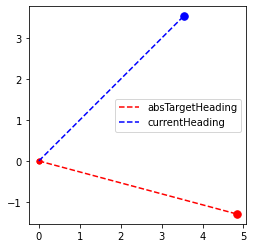

In [ ]:
# helper function
# returns -1 if num is negative, 1 otherwise
def sgn (num):
  if num >= 0:
    return 1
  else:
    return -1

# this function should subtract currentHeading from absTargetAngle
# the correct output should be stored in variable minAngle
def find_min_angle (absTargetAngle, currentHeading) :

  minAngle = absTargetAngle - currentHeading

  # idk why this works but it works
  if minAngle > 180 or minAngle < -180 :
    minAngle = -1 * sgn(minAngle) * (360 - abs(minAngle))

  # for visualization
  # ---------------------------------------------------------------------------------------------------------------------------------------
  print ('The minimum angle between {}(absTargetHeading) and {}(currentHeading) is {}.'.format(absTargetAngle, currentHeading, minAngle))
  add_complicated_line([[0, 0], [5*np.cos(absTargetAngle*np.pi/180), 5*np.sin(absTargetAngle*np.pi/180)]], '--', 'red', 'absTargetHeading')
  add_complicated_line([[0, 0], [5*np.cos(currentHeading*np.pi/180), 5*np.sin(currentHeading*np.pi/180)]], '--', 'blue', 'currentHeading')
  plt.plot(5*np.cos(absTargetAngle*np.pi/180), 5*np.sin(absTargetAngle*np.pi/180), '.', markersize=15, color='red')
  plt.plot(5*np.cos(currentHeading*np.pi/180), 5*np.sin(currentHeading*np.pi/180), '.', markersize=15, color='blue')
  plt.axis('scaled')
  plt.legend()
  plt.show()

# call the function to see result
find_min_angle(345, 45)

## **Moving Toward Target Point - Part 2**

With the linear error and the turn error obtained, we can calculate the robot's left and right side velocity based on those. Since the turn error is positive when the robot turns counterclockwise, the left side should have velocity `linearVel - turnVel` and the right side should have velocity `linearVel + turnVel`. In the code example below, a basic proportional controller is used to compute these two velocities. Please note that the animation code assumes `linearVel` and `turnVel` are in `velocityUnits::pct`.

To recap, the move to target point algorithm goes as follows (not real code):
```
// compute linear error
linearVel = sqrt(pow(targetY - currentY, 2) + pow(targetX - currentX, 2))

// compute turn error
absTargetAngle = atan2(targetY - currentY, targetX - currentX)
if absTargetAngle < 0 : absTargetAngle += 360
turnError = find_min_angle(absTargetAngle, currentHeading)

// compute linear and turn velocities using controller of your choice

// send commend to motors
left side motor speed =  linearVel - turnVel
right side motor speed = linearVel + turnVel
```

In [ ]:
def sgn (num):
  if num >= 0:
    return 1
  else:
    return -1

# set this to true if you use rotations
using_rotation = False

# return the computed turn velocity/turnVel and linear velocity/linVel (both in pct). positive turn vel means turning counterclockwise, negative turn vel means turning clockwise
# the function below will be used to create a nice animation.
# for the animation to work, please do not include any while loops in this function
# this about this function as a single 'step' within the complete move to point function
# keep in mind that the input and output of trig functions are in radians, NOT DEGREES!
def turn_to_pt_step (currentPos, currentHeading, targetPt) :

  # your code goes here
  # use any velocity controller you'd like



  return linearVel, turnVel

# THIS IS DIFFERENT THAN BEFORE! initialize variables here
currentPos = [0, 0]
targetPt = [7, 5]
currentHeading = 0

# this determines how long (how many frames) the animation will run. 400 frames takes around 30 seconds to compute.
numOfFrames = 200

# the code below is for animation
# -------------------------------------------------------------------------------------------------------------------------------------------------------------------
# for the sake of my sanity
pi = np.pi
# animation
fig = plt.figure()
trajectory_lines = plt.plot([], '-', color='orange', linewidth = 4)
trajectory_line = trajectory_lines[0]
heading_lines = plt.plot([], '-', color='red')
heading_line = heading_lines[0]
poses = plt.plot([], 'o', color='black', markersize=10)
pose = poses[0]

dt = 50
xs = [currentPos[0]]
ys = [currentPos[1]]
counter = 0

# other setup, stationay stuff for example
plt.axis("scaled")
initX = currentPos[0]
initY = currentPos[1]
plt.xlim (min([initX, targetPt[0]])-1, max([initX, targetPt[0]])+1)
plt.ylim (min([initY, targetPt[1]])-1, max([initY, targetPt[1]])+1)
plt.plot (currentPos[0], currentPos[1], '.', color='orange', markersize=15, label='currentPos')
plt.plot (targetPt[0], targetPt[1], '.', color='brown', markersize=15, label='targetPt')
plt.legend()

def move_to_point_animation (frame) :
  # define globals
  global currentPos
  global currentHeading
  global counter

  # add a short delay at the beginning
  if counter > 10:
    # call move_to_point_step to get info
    linearVel, turnVel = move_to_point_step (currentPos, currentHeading, targetPt)

    # model: 200rpm drive with 18" width
    #               rpm   /s  circ   feet
    maxLinVelfeet = 200 / 60 * pi*4 / 12
    #               rpm   /s  center angle   deg
    maxTurnVelDeg = 200 / 60 * pi*4 / 9 *180/pi

    # update x and y, but x and y stays constant here
    stepDis = linearVel/100 * maxLinVelfeet * dt/1000
    currentPos[0] += stepDis * np.cos(currentHeading*pi/180)
    currentPos[1] += stepDis * np.sin(currentHeading*pi/180)

    currentHeading += turnVel/100 * maxTurnVelDeg * dt/1000
    if using_rotation == False :
      currentHeading = currentHeading%360
      if currentHeading < 0: currentHeading += 360

  heading_line.set_data ([currentPos[0], currentPos[0] + 0.5*np.cos(currentHeading/180*pi)], [currentPos[1], currentPos[1] + 0.5*np.sin(currentHeading/180*pi)])

  # rest of the animation code
  xs.append(currentPos[0])
  ys.append(currentPos[1])

  pose.set_data ((currentPos[0], currentPos[1]))
  trajectory_line.set_data (xs, ys)

  # update counter
  counter += 1

anim = animation.FuncAnimation (fig, move_to_point_animation, frames = numOfFrames, interval = 50)
video = anim.to_html5_video()
html = display.HTML (video)
display.display(html)
plt.close()

### Move to Target Point: Commented Code Example

In [ ]:
def sgn (num):
  if num >= 0:
    return 1
  else:
    return -1

using_rotation = False

# return the computed turn velocity (in pct). positive turn vel means turning counterclockwise, negative turn vel means turning clockwise
# the function below will be used to create a nice animation.
# for the animation to work, please do not include any while loops in this function
# this about this function as a single 'step' within the complete turn to point function
# keep in mind that the input and output of trig functions are in radians, NOT DEGREES!
def move_to_point_step (currentPos, currentHeading, targetPt) :

  # initialize proportional controller constant
  Kp_lin = 20
  Kp_turn = 1

  # compute linear error
  linearError = np.sqrt((targetPt[1]-currentPos[1])**2 + (targetPt[0]-currentPos[0])**2)

  # calculate absTargetAngle with the atan2 function
  absTargetAngle = math.atan2 (targetPt[1]-currentPos[1], targetPt[0]-currentPos[0]) *180/pi
  if absTargetAngle < 0: absTargetAngle += 360

  # compute turn error by finding the minimum angle
  turnError = absTargetAngle - currentHeading
  if turnError > 180 or turnError < -180 :
    turnError = -1 * sgn(turnError) * (360 - abs(turnError))

  # apply proportional controller
  linearVel = Kp_lin * linearError
  turnVel = Kp_turn * turnError

  return linearVel, turnVel

# THIS IS DIFFERENT THAN BEFORE! initialize variables here
currentPos = [0, 0]
targetPt = [7, 5]
currentHeading = 0

# this determines how long (how many frames) the animation will run. 400 frames takes around 30 seconds to compute.
numOfFrames = 200

# the code below is for animation
# -------------------------------------------------------------------------------------------------------------------------------------------------------------------
# for the sake of my sanity
pi = np.pi
# animation
fig = plt.figure()
trajectory_lines = plt.plot([], '-', color='orange', linewidth = 4)
trajectory_line = trajectory_lines[0]
heading_lines = plt.plot([], '-', color='red')
heading_line = heading_lines[0]
poses = plt.plot([], 'o', color='black', markersize=10)
pose = poses[0]

dt = 50
xs = [currentPos[0]]
ys = [currentPos[1]]
counter = 0

# other setup, stationay stuff for example
plt.axis("scaled")
initX = currentPos[0]
initY = currentPos[1]
plt.xlim (min([initX, targetPt[0]])-1, max([initX, targetPt[0]])+1)
plt.ylim (min([initY, targetPt[1]])-1, max([initY, targetPt[1]])+1)
plt.plot (currentPos[0], currentPos[1], '.', color='orange', markersize=15, label='currentPos')
plt.plot (targetPt[0], targetPt[1], '.', color='brown', markersize=15, label='targetPt')
plt.legend()

def move_to_point_animation (frame) :
  # define globals
  global currentPos
  global currentHeading
  global counter

  # add a short delay at the beginning
  if counter > 10:
    # call move_to_point_step to get info
    linearVel, turnVel = move_to_point_step (currentPos, currentHeading, targetPt)

    # model: 200rpm drive with 18" width
    #               rpm   /s  circ   feet
    maxLinVelfeet = 200 / 60 * pi*4 / 12
    #               rpm   /s  center angle   deg
    maxTurnVelDeg = 200 / 60 * pi*4 / 9 *180/pi

    # update x and y, but x and y stays constant here
    stepDis = linearVel/100 * maxLinVelfeet * dt/1000
    currentPos[0] += stepDis * np.cos(currentHeading*pi/180)
    currentPos[1] += stepDis * np.sin(currentHeading*pi/180)

    currentHeading += turnVel/100 * maxTurnVelDeg * dt/1000
    if using_rotation == False :
      currentHeading = currentHeading%360
      if currentHeading < 0: currentHeading += 360

  heading_line.set_data ([currentPos[0], currentPos[0] + 0.5*np.cos(currentHeading/180*pi)], [currentPos[1], currentPos[1] + 0.5*np.sin(currentHeading/180*pi)])

  # rest of the animation code
  xs.append(currentPos[0])
  ys.append(currentPos[1])

  pose.set_data ((currentPos[0], currentPos[1]))
  trajectory_line.set_data (xs, ys)

  # update counter
  counter += 1

anim = animation.FuncAnimation (fig, move_to_point_animation, frames = numOfFrames, interval = 50)
video = anim.to_html5_video()
html = display.HTML (video)
display.display(html)
plt.close()

## Putting Everything Together

It is natural to think that the pure pursuit controller is essentially just repeatedly moving toward target points that reside on the path, but with the linear error set to length of the remaining path. From our past experience, this basic implementation worked decently well for VRC. The original pure pursuit controller, which is used for bicycle model vehicles, calculates angular velocity in a slightly different and more complicated way. It's adaptation to differential drive robots will be briefly discussed in the next section. Before combining all the steps together, let's quickly recap what those components are:

* Line-circle intersection with bounds
* Goal point search and selection
* Find the appropiate turn error and compute the turn velocity

You might be wondering where are calculating the linear (forward) velocity. The answer is: it can be anything. The linear velocity of the robot can be computed separately with a controller of your choice. You can make it constant, proportional to the remaining distance in the path, or apply some fancy algorithms to it. As mentioned earlier, the pure pursuit controller is an automatic steering controller that outputs appropriate angular velocities.

One parameter that greatly affects the controller's performance is the look ahead distance $l_d$. You might think that the smaller this distance is the better, but small look ahead distance are prone to more oscillations. On the other hand, large look ahead distance often creates the problem of "cutting corners". From experience, I have found that typical look ahead distance ranges from 0.7 ft to 1.5 ft for a VRC robot. I would suggest try not to set the look ahead distance below 0.5 ft. Although the simulation might look more perfect, in real world the robot will not be able to function well with look ahead distance as short as 0.5 ft.

<img src = "https://drive.google.com/uc?export=view&id=1R2-KlXBMu6CPy4nZ9FWjVUBkylYhPmxU" width = '500'>

The code cell below can be used for implementing the complete algorithm yourself. The sample path provided is a closed loop, so constant longitudinal velocity will work just fine with this path. You are encouraged to try out different control laws and different paths. For paths that are not a closed loop, you'll need to think about how to make the robot stop properly at the end of the path. There are many ways to accomplish this and it will be left for the readers to figure out.

In [ ]:
path1 = [[0.0, 0.0], [0.571194595265405, -0.4277145118491421], [1.1417537280142898, -0.8531042347260006], [1.7098876452457967, -1.2696346390611464], [2.2705328851607995, -1.6588899151216996], [2.8121159420106827, -1.9791445882187304], [3.314589274316711, -2.159795566252656], [3.7538316863009027, -2.1224619985315876], [4.112485112342358, -1.8323249172947023], [4.383456805594431, -1.3292669972090994], [4.557386228943757, -0.6928302521681386], [4.617455513800438, 0.00274597627737883], [4.55408382321606, 0.6984486966257434], [4.376054025556597, 1.3330664239172116], [4.096280073621794, 1.827159263675668], [3.719737492364894, 2.097949296701878], [3.25277928312066, 2.108933125822431], [2.7154386886417314, 1.9004760368018616], [2.1347012144725985, 1.552342808106984], [1.5324590525923942, 1.134035376721349], [0.9214084611203568, 0.6867933269918683], [0.30732366808208345, 0.22955002391894264], [-0.3075127599907512, -0.2301742560363831], [-0.9218413719658775, -0.6882173194028102], [-1.5334674079795052, -1.1373288016589413], [-2.1365993767877467, -1.5584414896876835], [-2.7180981380280307, -1.9086314914221845], [-3.2552809639439704, -2.1153141204181285], [-3.721102967810494, -2.0979137913841046], [-4.096907306768644, -1.8206318841755131], [-4.377088212533404, -1.324440752295139], [-4.555249804461285, -0.6910016662308593], [-4.617336323713965, 0.003734984720118972], [-4.555948690867849, 0.7001491248072772], [-4.382109193278264, 1.3376838311365633], [-4.111620918085742, 1.8386823176628544], [-3.7524648889185794, 2.1224985058331005], [-3.3123191098095615, 2.153588702898333], [-2.80975246649598, 1.9712114570096653], [-2.268856462266256, 1.652958931009528], [-1.709001159778989, 1.2664395490411673], [-1.1413833971013372, 0.8517589252820573], [-0.5710732645795573, 0.4272721367616211], [0, 0], [0.571194595265405, -0.4277145118491421]]

# helper functions
def pt_to_pt_distance (pt1,pt2):
    distance = np.sqrt((pt2[0] - pt1[0])**2 + (pt2[1] - pt1[1])**2)
    return distance

# returns -1 if num is negative, 1 otherwise
def sgn (num):
  if num >= 0:
    return 1
  else:
    return -1

# THIS IS DIFFERENT THAN BEFORE! initialize variables here
currentPos = [0, 0]
currentHeading = 0
lastFoundIndex = 0
lookAheadDis = 0.8
linearVel = 100

# set this to true if you use rotations
using_rotation = False

# this determines how long (how many frames) the animation will run. 400 frames takes around 30 seconds to compute.
numOfFrames = 400

# this function needs to return 3 things IN ORDER: goalPt, lastFoundIndex, turnVel
# think about this function as a snapshot in a while loop
# given all information about the robot's current state, what should be the goalPt, lastFoundIndex, and turnVel?
# the LFindex takes in the value of lastFoundIndex as input.
# it is this way because I don't want the global lastFoundIndex to get modified in this function, instead, this function returns the updated lastFoundIndex value
# this function will be feed into another function for creating animation
def pure_pursuit_step (path, currentPos, currentHeading, lookAheadDis, LFindex) :

  # copy the global value of lastFOundIndex to a local variable with the same name
  # return this local variable at the end of the function
  lastFoundIndex = LFindex

  # 3 components of our basic pure pursuit controller:
  #   1. line-circle intersection with bounds
  #   2. choosing the appropriate goal point
  #   3. compute the correct turn error and turn velocity using a controller of your choice

  # your code goes here







  return goalPt, lastFoundIndex, turnVel

# the code below is for animation
# -------------------------------------------------------------------------------------------------------------------------------------------------------------------
# for the sake of my sanity
pi = np.pi
# animation
fig = plt.figure()
trajectory_lines = plt.plot([], '-', color='orange', linewidth = 4)
trajectory_line = trajectory_lines[0]
heading_lines = plt.plot([], '-', color='red')
heading_line = heading_lines[0]
connection_lines = plt.plot([], '-', color='green')
connection_line = connection_lines[0]
poses = plt.plot([], 'o', color='black', markersize=10)
pose = poses[0]

# other setup, stationay stuff for example
# plt.plot([initX], [initY], 'x',color='red',markersize=10)
# plt.plot([path1[-1][0]], [path1[-1][1]], 'x',color='red',markersize=10)
pathForGraph = np.array(path1)
plt.plot(pathForGraph[:, 0], pathForGraph[:, 1], '--', color='grey')
# plt.plot(pathForGraph[:, 0], pathForGraph[:, 1], 'o', color='purple', markersize=2)

plt.axis("scaled")
plt.xlim (-6, 6)
plt.ylim (-4, 4)
dt = 50
xs = [currentPos[0]]
ys = [currentPos[1]]

def pure_pursuit_animation (frame) :
  # define globals
  global currentPos
  global currentHeading
  global lastFoundIndex
  global linearVel

  # for the animation to loop
  if lastFoundIndex >= len(path1)-2 : lastFoundIndex = 0

  # call pure_pursuit_step to get info
  goalPt, lastFoundIndex, turnVel = pure_pursuit_step (path1, currentPos, currentHeading, lookAheadDis, lastFoundIndex)

  # model: 200rpm drive with 18" width
  #               rpm   /s  circ   feet
  maxLinVelfeet = 200 / 60 * pi*4 / 12
  #               rpm   /s  center angle   deg
  maxTurnVelDeg = 200 / 60 * pi*4 / 9 *180/pi

  # update x and y, but x and y stays constant here
  stepDis = linearVel/100 * maxLinVelfeet * dt/1000
  currentPos[0] += stepDis * np.cos(currentHeading*pi/180)
  currentPos[1] += stepDis * np.sin(currentHeading*pi/180)

  heading_line.set_data ([currentPos[0], currentPos[0] + 0.5*np.cos(currentHeading/180*pi)], [currentPos[1], currentPos[1] + 0.5*np.sin(currentHeading/180*pi)])
  connection_line.set_data ([currentPos[0], goalPt[0]], [currentPos[1], goalPt[1]])

  currentHeading += turnVel/100 * maxTurnVelDeg * dt/1000
  if using_rotation == False :
    currentHeading = currentHeading%360
    if currentHeading < 0: currentHeading += 360

  # rest of the animation code
  xs.append(currentPos[0])
  ys.append(currentPos[1])

  pose.set_data ((currentPos[0], currentPos[1]))
  trajectory_line.set_data (xs, ys)

anim = animation.FuncAnimation (fig, pure_pursuit_animation, frames = numOfFrames, interval = 50)
video = anim.to_html5_video()
html = display.HTML (video)
display.display(html)
plt.close()

### Putting Everything Together: Commented Code Example

In [ ]:
path1 = [[0.0, 0.0], [0.571194595265405, -0.4277145118491421], [1.1417537280142898, -0.8531042347260006], [1.7098876452457967, -1.2696346390611464], [2.2705328851607995, -1.6588899151216996], [2.8121159420106827, -1.9791445882187304], [3.314589274316711, -2.159795566252656], [3.7538316863009027, -2.1224619985315876], [4.112485112342358, -1.8323249172947023], [4.383456805594431, -1.3292669972090994], [4.557386228943757, -0.6928302521681386], [4.617455513800438, 0.00274597627737883], [4.55408382321606, 0.6984486966257434], [4.376054025556597, 1.3330664239172116], [4.096280073621794, 1.827159263675668], [3.719737492364894, 2.097949296701878], [3.25277928312066, 2.108933125822431], [2.7154386886417314, 1.9004760368018616], [2.1347012144725985, 1.552342808106984], [1.5324590525923942, 1.134035376721349], [0.9214084611203568, 0.6867933269918683], [0.30732366808208345, 0.22955002391894264], [-0.3075127599907512, -0.2301742560363831], [-0.9218413719658775, -0.6882173194028102], [-1.5334674079795052, -1.1373288016589413], [-2.1365993767877467, -1.5584414896876835], [-2.7180981380280307, -1.9086314914221845], [-3.2552809639439704, -2.1153141204181285], [-3.721102967810494, -2.0979137913841046], [-4.096907306768644, -1.8206318841755131], [-4.377088212533404, -1.324440752295139], [-4.555249804461285, -0.6910016662308593], [-4.617336323713965, 0.003734984720118972], [-4.555948690867849, 0.7001491248072772], [-4.382109193278264, 1.3376838311365633], [-4.111620918085742, 1.8386823176628544], [-3.7524648889185794, 2.1224985058331005], [-3.3123191098095615, 2.153588702898333], [-2.80975246649598, 1.9712114570096653], [-2.268856462266256, 1.652958931009528], [-1.709001159778989, 1.2664395490411673], [-1.1413833971013372, 0.8517589252820573], [-0.5710732645795573, 0.4272721367616211], [0, 0], [0.571194595265405, -0.4277145118491421]]
# path1 = [[-4, -2], [-4, 2], [4, 2], [4, -2], [-4, -2]]

# helper functions
def pt_to_pt_distance (pt1,pt2):
    distance = np.sqrt((pt2[0] - pt1[0])**2 + (pt2[1] - pt1[1])**2)
    return distance

# returns -1 if num is negative, 1 otherwise
def sgn (num):
  if num >= 0:
    return 1
  else:
    return -1

# THIS IS DIFFERENT THAN BEFORE! initialize variables here
# you can also change the Kp constant which is located at line 113
currentPos = [0, 0]
currentHeading = 330
lastFoundIndex = 0
lookAheadDis = 0.8
linearVel = 100

# set this to true if you use rotations
using_rotation = False

# this determines how long (how many frames) the animation will run. 400 frames takes around 30 seconds.
numOfFrames = 400

# this function needs to return 3 things in the following order: goalPt, lastFoundIndex, turnVel
# think about this function as a snapshot in a while loop
# given all information about the robot's current state, what should be the goalPt, lastFoundIndex, and turnVel?
# the LFindex takes in the value of lastFoundIndex as input. Looking at it now I can't remember why I have it.
# it is this way because I don't want the global lastFoundIndex to get modified in this function, instead, this function returns the updated lastFoundIndex value
# this function will be feed into another function for creating animation
def pure_pursuit_step (path, currentPos, currentHeading, lookAheadDis, LFindex) :

  # extract currentX and currentY
  currentX = currentPos[0]
  currentY = currentPos[1]

  # use for loop to search intersections
  lastFoundIndex = LFindex
  intersectFound = False
  startingIndex = lastFoundIndex

  for i in range (startingIndex, len(path)-1):

    # beginning of line-circle intersection code
    x1 = path[i][0] - currentX
    y1 = path[i][1] - currentY
    x2 = path[i+1][0] - currentX
    y2 = path[i+1][1] - currentY
    dx = x2 - x1
    dy = y2 - y1
    dr = math.sqrt (dx**2 + dy**2)
    D = x1*y2 - x2*y1
    discriminant = (lookAheadDis**2) * (dr**2) - D**2

    if discriminant >= 0:
      sol_x1 = (D * dy + sgn(dy) * dx * np.sqrt(discriminant)) / dr**2
      sol_x2 = (D * dy - sgn(dy) * dx * np.sqrt(discriminant)) / dr**2
      sol_y1 = (- D * dx + abs(dy) * np.sqrt(discriminant)) / dr**2
      sol_y2 = (- D * dx - abs(dy) * np.sqrt(discriminant)) / dr**2

      sol_pt1 = [sol_x1 + currentX, sol_y1 + currentY]
      sol_pt2 = [sol_x2 + currentX, sol_y2 + currentY]
      # end of line-circle intersection code

      minX = min(path[i][0], path[i+1][0])
      minY = min(path[i][1], path[i+1][1])
      maxX = max(path[i][0], path[i+1][0])
      maxY = max(path[i][1], path[i+1][1])

      # if one or both of the solutions are in range
      if ((minX <= sol_pt1[0] <= maxX) and (minY <= sol_pt1[1] <= maxY)) or ((minX <= sol_pt2[0] <= maxX) and (minY <= sol_pt2[1] <= maxY)):

        foundIntersection = True

        # if both solutions are in range, check which one is better
        if ((minX <= sol_pt1[0] <= maxX) and (minY <= sol_pt1[1] <= maxY)) and ((minX <= sol_pt2[0] <= maxX) and (minY <= sol_pt2[1] <= maxY)):
          # make the decision by compare the distance between the intersections and the next point in path
          if pt_to_pt_distance(sol_pt1, path[i+1]) < pt_to_pt_distance(sol_pt2, path[i+1]):
            goalPt = sol_pt1
          else:
            goalPt = sol_pt2

        # if not both solutions are in range, take the one that's in range
        else:
          # if solution pt1 is in range, set that as goal point
          if (minX <= sol_pt1[0] <= maxX) and (minY <= sol_pt1[1] <= maxY):
            goalPt = sol_pt1
          else:
            goalPt = sol_pt2

        # only exit loop if the solution pt found is closer to the next pt in path than the current pos
        if pt_to_pt_distance (goalPt, path[i+1]) < pt_to_pt_distance ([currentX, currentY], path[i+1]):
          # update lastFoundIndex and exit
          lastFoundIndex = i
          break
        else:
          # in case for some reason the robot cannot find intersection in the next path segment, but we also don't want it to go backward
          lastFoundIndex = i+1

      # if no solutions are in range
      else:
        foundIntersection = False
        # no new intersection found, potentially deviated from the path
        # follow path[lastFoundIndex]
        goalPt = [path[lastFoundIndex][0], path[lastFoundIndex][1]]

    # if determinant < 0
    else:
      foundIntersection = False
      # no new intersection found, potentially deviated from the path
      # follow path[lastFoundIndex]
      goalPt = [path[lastFoundIndex][0], path[lastFoundIndex][1]]

  # obtained goal point, now compute turn vel
  # initialize proportional controller constant
  Kp = 3

  # calculate absTargetAngle with the atan2 function
  absTargetAngle = math.atan2 (goalPt[1]-currentPos[1], goalPt[0]-currentPos[0]) *180/pi
  if absTargetAngle < 0: absTargetAngle += 360

  # compute turn error by finding the minimum angle
  turnError = absTargetAngle - currentHeading
  if turnError > 180 or turnError < -180 :
    turnError = -1 * sgn(turnError) * (360 - abs(turnError))

  # apply proportional controller
  turnVel = Kp*turnError

  return goalPt, lastFoundIndex, turnVel

# the code below is for animation
# -------------------------------------------------------------------------------------------------------------------------------------------------------------------
# for the sake of my sanity
pi = np.pi
# animation
fig = plt.figure()
trajectory_lines = plt.plot([], '-', color='orange', linewidth = 4)
trajectory_line = trajectory_lines[0]
heading_lines = plt.plot([], '-', color='red')
heading_line = heading_lines[0]
connection_lines = plt.plot([], '-', color='green')
connection_line = connection_lines[0]
poses = plt.plot([], 'o', color='black', markersize=10)
pose = poses[0]

# other setup, stationay stuff for example
# plt.plot([initX], [initY], 'x',color='red',markersize=10)
# plt.plot([path1[-1][0]], [path1[-1][1]], 'x',color='red',markersize=10)
pathForGraph = np.array(path1)
plt.plot(pathForGraph[:, 0], pathForGraph[:, 1], '--', color='grey')
# plt.plot(pathForGraph[:, 0], pathForGraph[:, 1], 'o', color='purple', markersize=2)

plt.axis("scaled")
plt.xlim (-6, 6)
plt.ylim (-4, 4)
dt = 50
xs = [currentPos[0]]
ys = [currentPos[1]]

def pure_pursuit_animation (frame) :
  # define globals
  global currentPos
  global currentHeading
  global lastFoundIndex
  global linearVel

  # for the animation to loop
  if lastFoundIndex >= len(path1)-2 : lastFoundIndex = 0

  # call pure_pursuit_step to get info
  goalPt, lastFoundIndex, turnVel = pure_pursuit_step (path1, currentPos, currentHeading, lookAheadDis, lastFoundIndex)

  # model: 200rpm drive with 18" width
  #               rpm   /s  circ   feet
  maxLinVelfeet = 200 / 60 * pi*4 / 12
  #               rpm   /s  center angle   deg
  maxTurnVelDeg = 200 / 60 * pi*4 / 9 *180/pi

  # update x and y, but x and y stays constant here
  stepDis = linearVel/100 * maxLinVelfeet * dt/1000
  currentPos[0] += stepDis * np.cos(currentHeading*pi/180)
  currentPos[1] += stepDis * np.sin(currentHeading*pi/180)

  heading_line.set_data ([currentPos[0], currentPos[0] + 0.5*np.cos(currentHeading/180*pi)], [currentPos[1], currentPos[1] + 0.5*np.sin(currentHeading/180*pi)])
  connection_line.set_data ([currentPos[0], goalPt[0]], [currentPos[1], goalPt[1]])

  currentHeading += turnVel/100 * maxTurnVelDeg * dt/1000
  if using_rotation == False :
    currentHeading = currentHeading%360
    if currentHeading < 0: currentHeading += 360

  # rest of the animation code
  xs.append(currentPos[0])
  ys.append(currentPos[1])

  pose.set_data ((currentPos[0], currentPos[1]))
  trajectory_line.set_data (xs, ys)

anim = animation.FuncAnimation (fig, pure_pursuit_animation, frames = numOfFrames, interval = 50)
video = anim.to_html5_video()
html = display.HTML (video)
display.display(html)
plt.close()

## **Additional Information**

### **Going Back to Angular Velocity**

As mentioned above, the original pure pursuit controller calculates angular velocity in a different way. The robot is expected to travel an arc that intersects both its current position and the goal point, with an additional constraint that the arc has to be tangent to the line connecting the front and back wheel of the robot. During the process of traveling this arc, the robot's angular velocity stays constant. In our implementation above, for the robot to reach the goal point, its angular velocity changes as turn error changes. The difference is illustrated in the picture below:

<img src = "https://drive.google.com/uc?export=view&id=1rin4vR9_n6e0fGw2VMs0eOkNWTuV8w68" width = '600'>

To adapt this arc traveling behavior into differential drive robots, consider the following question: assume the robot's linear velocity stays constant and the robot width is known, what velocity difference does the left and right side of the robot need to have to produce this arc trajectory?

In order to compute the appropiate turn velocity, we first need to find the radius of the arc we want the robot to travel (denoted as $\mathrm{R}$ in the picture below).

<img src = "https://drive.google.com/uc?export=view&id=14tX_uUZ9IbuxRbTLhT4U_ohQah8VXPSI" width = '600'>

This is easy to compute using trigonometry. Using the right triangle on the bottom, we can obtain:

$$\mathrm{R = \frac{look \ ahead \ distance / 2}{sin(turn \ error)}}$$

Next, consider the diagram below:

<img src = "https://drive.google.com/uc?export=view&id=1X9jKLJ4l-wFXba0oFDA8HmzfBOc5sZV1" width = '500'>

Denote the distance traveled by the left side of the robot as $\mathrm{L_l}$ and the distance traveled by the right side of the robot as $\mathrm{L_r}$. Assume the robot finishes traveling the arc after time $\mathrm{\Delta t}$. Since the left side of the robot has velocity `linearVel - turnVel` and the right side of the robot has velocity `linearVel + turnVel`, we can obtain the following equations:

$$\mathrm{L_l =  (linearVel - turnVel)\cdot\Delta t = (R - W/2)\cdot(2 \cdot turnError)}$$

$$\mathrm{L_r = (linearVel + turnVel)\cdot\Delta t = (R + W/2)\cdot(2 \cdot turnError)}$$

<br>

Divide the first equation by the second equation, we get:

$$\mathrm{\frac {(linearVel - turnVel)\cdot\Delta t} {(linearVel + turnVel)\cdot\Delta t} = \frac {(R - W/2)\cdot(2 \cdot turnError)} {(R + W/2)\cdot(2 \cdot turnError)}}$$

<br>

$$\mathrm{\frac {linearVel - turnVel} {linearVel + turnVel} = \frac {R - W/2} {R + W/2}}$$

<br>

$$\mathrm{(R + W/2) \cdot linearVel - (R + W/2) \cdot turnVel = (R - W/2) \cdot linearVel + (R - W/2) \cdot turnVel}$$

<br>

Which can be further simplified to
$$\mathrm{turnVel = \frac {W} {2R} \cdot linearVel}$$

<br>

Substitute $\mathrm{R}$ with $\mathrm{\frac{look \ ahead \ distance / 2}{sin(turn \ error)}}$, we obtain the final expression for $\mathrm{turnVel}$:

$$\mathrm{turnVel = \frac {W \cdot sin(turn \ error)} {look \ ahead \ distance} \cdot linearVel}$$

<br>

### **Generate Way Points**

The pure pursuit controller does not generate paths for the robot to follow. Instead, all paths fed into the function must be pre-computed. During the past season, our team has been using [this Colab notebook](https://colab.research.google.com/drive/10FAZWfpz0TzWq7MdG9dbxUq_ZiDGPt_w?usp=sharing) when we need to manually compute and modify paths.This work is heavily inspired by the work of FRC team 2168.


## **What Next?**

Hopefully this document has been somewhat helpful to you. Please note that this document did not cover all the details needed to implement the pure pursuit controller on a physical robot. A short list of implementation details to think about:
* Ending condition to exit the path
* The physical speed limit - turnVel and linearVel add up to the maximum speed of the robot

There is a lot more if you dig deeper - optimizing the robot velocity according to the path curvature, adjusting the look ahead distance and look ahead point to reduce the cutting corner problem, etc. If you would like to read more about pure pursuit and some other steering methods, going through [this research paper](https://www.ri.cmu.edu/pub_files/2009/2/Automatic_Steering_Methods_for_Autonomous_Automobile_Path_Tracking.pdf) by Jarrod M. Snider is highly recommended. There are many interesting variations (and improvements) of the pure pursuit controller out there if you search on Google Scholar.